# mcTEC fate prediction with STEMNET
*Author: Lena Boehme, Taghon lab, 2024*

In the paediatric thymus we identified two niches of TEC progenitor cells, in the capsular region and in the CMJ. To assess whether these two subsets differed in their potential to become either mTECs or cTECs, we used STEMNET to assess priming towards either lineage.

### Setup

In [3]:
options(repr.plot.width=12, repr.plot.height=6)

options(scipen=100) #avoid scientific notation of numbers

In [4]:
library(SeuratDisk)
library(Seurat)
library(matrixStats)
library(ggplot2)
library(pheatmap)
library(reshape2)
library(dplyr)
library(tidyr)
library(viridis)
library(batchelor)
library(BiocParallel)
library(BiocNeighbors)
library(STEMNET)
library(sceasy)
library(RColorBrewer)
library(ggrastr)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching SeuratObject


Attaching package: ‘dplyr’


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: viridisLite

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMea

In [3]:
pal1 <- colorRampPalette(brewer.pal(8, "Set1"))(8)
pal2 <- pal1[c(1:3,6:8,4,5)]
pal3 <- colorRampPalette(brewer.pal(12, "Paired"))(12)
pal4 <- pal3[c(1:7,9,12)]

In [4]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Brussels
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-3          sceasy_0.0.7               
 [3] reticulate_1.35.0           STEMNET_0.1                
 [5] BiocNeighbors_1.20.2        BiocParallel_1.36.0        
 [7] batchel

In [5]:
#sceasy::convertFormat('TEC_pead_scvi_updated_2024-01-08.h5ad', from="anndata", to="seurat", outFile='TECs.rds')

TEC gene expression data:

In [4]:
seurObj_TEC <- readRDS('TECs.rds')

In [7]:
seurObj_TEC
seurObj_TEC@meta.data %>% head()
table(seurObj_TEC$cell_type_level_4_upd)

An object of class Seurat 
36601 features across 15807 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: scVI, umap, protein_expression

nFeaturess_RNA
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA  470          
TA13072427-CTGATCCAGTACGCCC         656          
TA13072427-GCACATACAGCGTTCG         448          
TA13072428-ACAGCTATCTACGAGT         659          
GSM4466785-ACGATACAGTCTCGGC         414          
GSM4466783-TGCGGGTGTTTCGGCG        5769          
                                   sample_barcode                           
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA T07_TH_EPCAM_S3-CGAGCACGTTCCTCCA         
TA13072427-CTGATCCAGTACGCCC        U48-THY-0-SC-1_5GEX-CTGATCCAGTACGCCC     
TA13072427-GCACATACAGCGTTCG        U48-THY-0-SC-1_5GEX-GCACATACAGCGTTCG     
TA13072428-ACAGCTATCTACGAGT        U48-THY-0-SC-EPCP-1_5GEX-ACAGCTATCTACGAGT
GSM4466785-ACGATACAGTCTCGGC        baut6-ACGATACAGTCTCGGC                   
GSM4466783-TGCGGGTGTTTCGGCG        baut4-TGCGGGTGTTTCGGCG                   
                                   batch chemistry_simple age_group  
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA 134   5GEX             paed(early)
TA13072427-CTGATCCAGTACGCCC        139   5GEX             paed(early)
TA13072427-GCACATACAGCGTTCG        139   5GEX             paed(early)
TA13072428-ACAGCTATCTACGAGT        140   5GEX             paed(early)
GSM4466785-ACGATACAGTCTCGGC        123   3GEX             paed(early)
GSM4466783-TGCGGGTGTTTCGGCG        121   3GEX             paed(early)
                                   age_numeric sampleID_TCRab
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA  3          NA            
TA13072427-CTGATCCAGTACGCCC         6          TA13072430    
TA13072427-GCACATACAGCGTTCG         6          TA13072430    
TA13072428-ACAGCTATCTACGAGT         6          TA13072431    
GSM4466785-ACGATACAGTCTCGGC        10          NA            
GSM4466783-TGCGGGTGTTTCGGCG         1          NA            
                                   path_TCRab                                                                
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA NA                                                                        
TA13072427-CTGATCCAGTACGCCC        lustre/scratch126/cellgen/cellgeni/tickets/tic-1930/tcr_results/TA13072430
TA13072427-GCACATACAGCGTTCG        lustre/scratch126/cellgen/cellgeni/tickets/tic-1930/tcr_results/TA13072430
TA13072428-ACAGCTATCTACGAGT        lustre/scratch126/cellgen/cellgeni/tickets/tic-1930/tcr_results/TA13072431
GSM4466785-ACGATACAGTCTCGGC        NA                                                                        
GSM4466783-TGCGGGTGTTTCGGCG        NA                                                                        
                                   path_cellbender_gex                                                                    
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA /lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/T07_TH_EPCAM_5GEX
TA13072427-CTGATCCAGTACGCCC        /lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/TA13072427       
TA13072427-GCACATACAGCGTTCG        /lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/TA13072427       
TA13072428-ACAGCTATCTACGAGT        /lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/TA13072428       
GSM4466785-ACGATACAGTCTCGGC        /lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GSM4466785       
GSM4466783-TGCGGGTGTTTCGGCG        /lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GSM4466783       
                                   study        ⋯ anno_CITE
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA Park2020     ⋯ nan      
TA13072427-CTGATCCAGTACGCCC        HTSA_Sanger  ⋯ nan      
TA13072427-GCACATACAGCGTTCG        HTSA_Sanger  ⋯ nan      
TA13072428-ACAGCTATCTACGAGT        HTSA_Sanger  ⋯ nan      
GSM4466785-ACGATACAGTCTCGGC        Bautista2021 ⋯ nan      
GSM4466783-TGCGGGTGTTTCGGCG        Bautista2021 ⋯ nan      
                                   cell_type_level_4_explore leiden_r1.0
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA mTECII                    9          
TA13072427-CTGATCCAGTACGC


        cTECI        cTECII       cTECIII         mcTEC  mcTEC-Prolif 
         1983          1615          2146          3116            72 
        mTECI  mTECI-Prolif   mTECI-trans        mTECII       mTECIII 
         2756           164           297           671           746 
    TEC-neuro TEC-cilliated       TEC-myo TEC-ionocytes 
         1226           478           506            31 

In [8]:
Idents(seurObj_TEC) <- seurObj_TEC$cell_type_level_4_upd

Remove mimetic TECs, not relevant for this analysis.

In [9]:
seurObj_TEC_subs <- subset(seurObj_TEC, idents = c('mTECI-Prolif','TEC-neuro', 'TEC-ionocytes', 'TEC-cilliated', 'TEC-myo','mTECI-trans'), invert=T)

In [10]:
seurObj_TEC_subs$TEC <- gsub('I', '', as.character(seurObj_TEC_subs$cell_type_level_4_upd)) %>% gsub('-Prolif', '', .)

### STEMNET run - cTECI-III and mTECI-III
STEMNET takes a 'population' vector, which specifies for each cell if it represents a developmental endpoint (and which) or otherwise NA (which identifies the cell as a 'stem'cell). We create a vector with the identities for each cell, whereby all mcTECs are considered stem cells and the cTEC/mTEC types the mature endpoints.

In [11]:
cellident <- seurObj_TEC_subs$cell_type_level_4_explore
cellident <- gsub('mcTEC-Prolif', NA, cellident) %>% as.character()
cellident <- gsub('mcTEC', NA, cellident) %>% as.character()

table(cellident)

cellident
  cTECI  cTECII cTECIII   mTECI  mTECII mTECIII 
   1983    1615    2146    2756     671     746 

STEMNET requies a dense matrix of logcounts. We can decide to only select the HVGs if the full RNA data is too noisy or big.

In [12]:
data <- as.matrix(t(seurObj_TEC_subs@assays$RNA@data))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.6 GiB”


In [ ]:
ptm <- proc.time()

stemnet <- runSTEMNET(data=data, populations=cellident)

proc.time() - ptm

stemnet

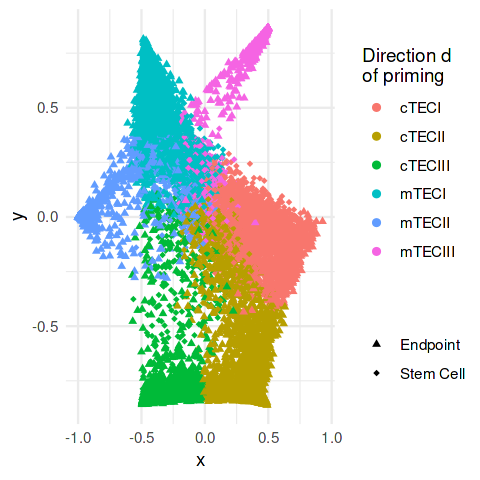

In [22]:
stemnet_plot <- plot(stemnet)

stemnet_df <- stemnet_plot$PlotData
stemnet_df$ident <- seurObj_TEC_subs$cell_type_level_4_upd
stemnet_df$ident_new <- seurObj_TEC_subs$cell_type_level_4_upd2
stemnet_df$TEC <- seurObj_TEC_subs$TEC

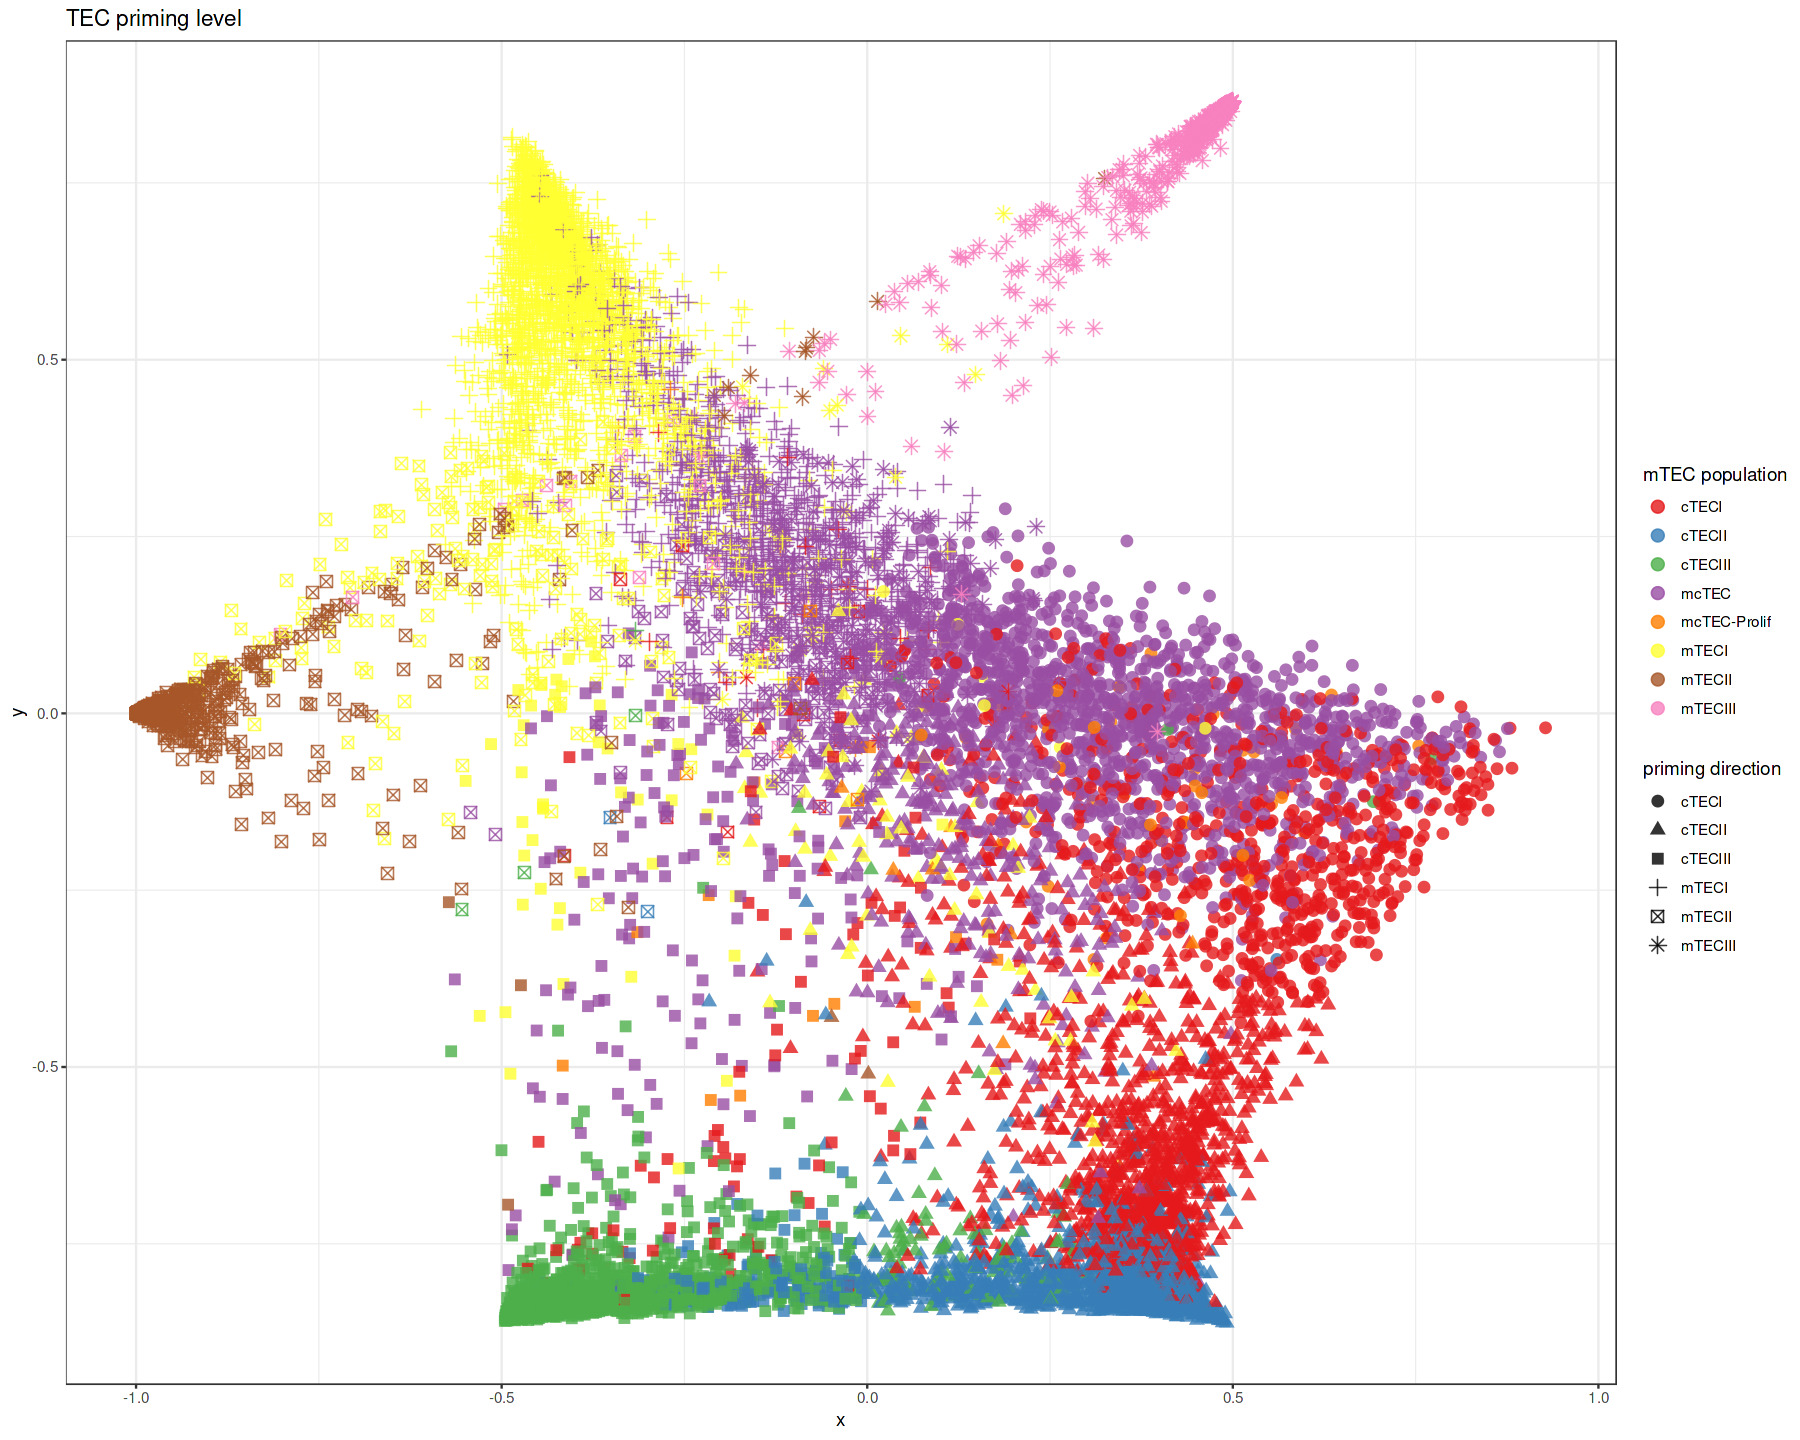

In [8]:
options(repr.plot.width=15, repr.plot.height=12)

ggplot(stemnet_df, aes(x=x, y=y, shape=direction, color=ident))+
       geom_point(size=3, alpha=0.8)+
        scale_color_manual(values = pal1)+
        theme_bw()+
        labs(title = 'TEC priming level', color='mTEC population', shape='priming direction')

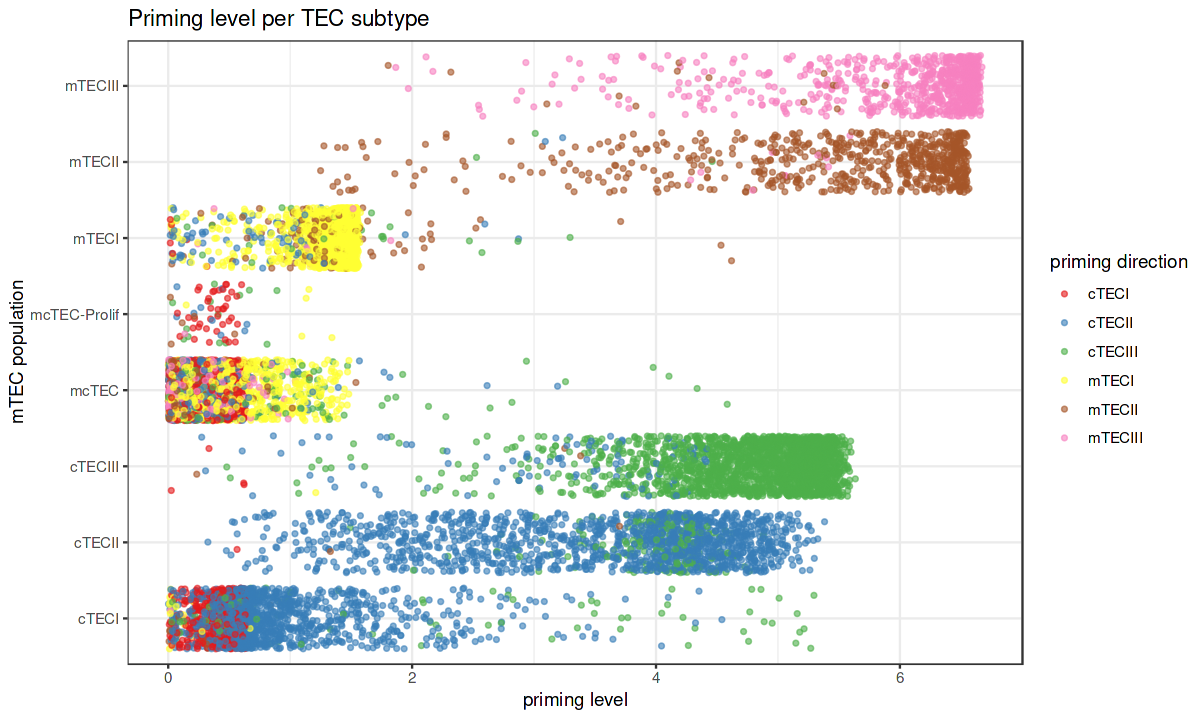

In [7]:
options(repr.plot.width=10, repr.plot.height=6)


ggplot(stemnet_df, aes(x=amount, y=ident, color=direction))+
geom_jitter(size=1, alpha=0.6)+
scale_color_manual(values = pal2)+
labs(title='Priming level per TEC subtype', x='priming level', y='mTEC population', color='priming direction')+
theme_bw()

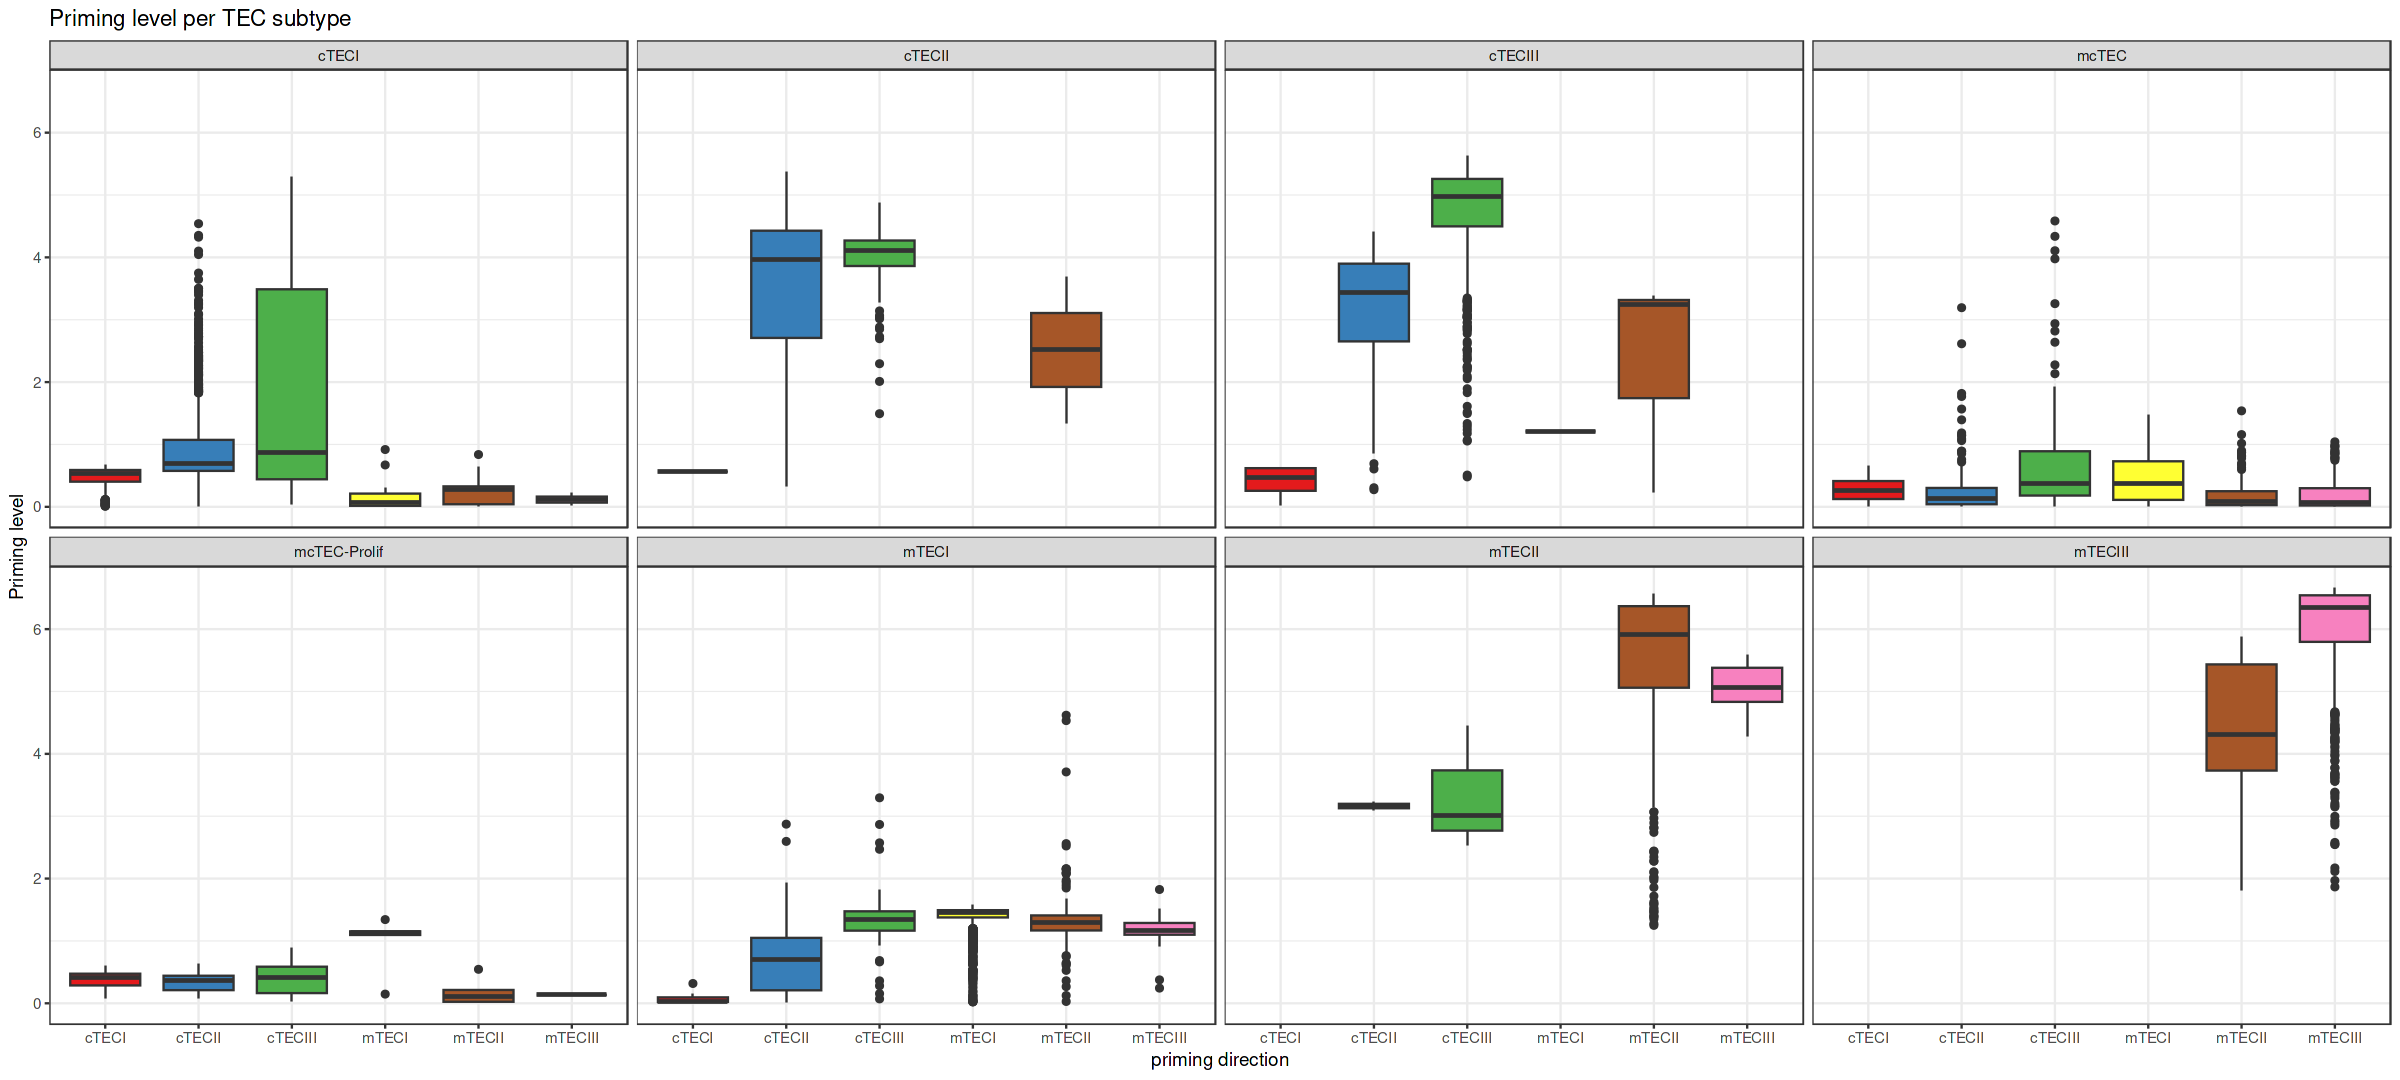

In [6]:
options(repr.plot.width=20, repr.plot.height=9)

ggplot(stemnet_df, aes(y=amount, x=direction, fill=direction))+
geom_boxplot()+
facet_wrap(~ident, ncol=4)+
scale_fill_manual(values = pal2)+
labs(title='Priming level per TEC subtype', y='Priming level', x='priming direction')+
theme_bw()&NoLegend()

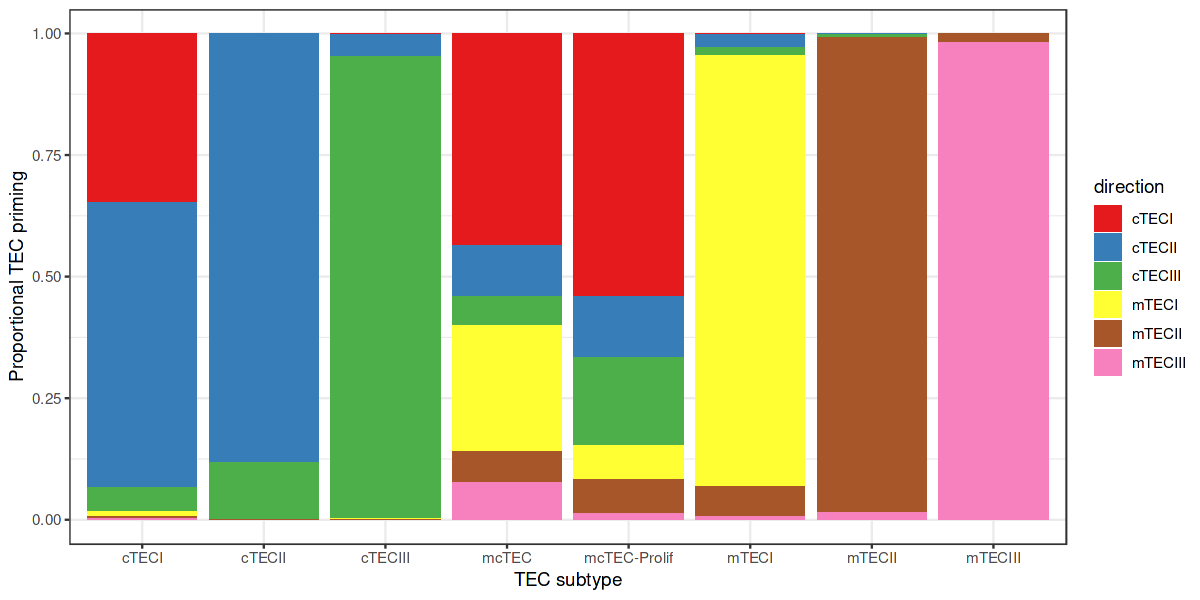

In [26]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(stemnet_df, aes(x=ident, fill=direction))+
geom_bar(stat = 'count', position='fill')+
scale_fill_manual(values = pal2)+
labs('Proportional priming per TEC subtype (split mcTEC)', y='Proportional TEC priming', x='TEC subtype', color='priming direction')+
theme_bw()

### STEMNET run - total cTEC vs. mTEC

Instead of assuming 6 different TEC fates, we can combine the cTEC and mTEC subtypes and evaluate overall mTEC vs. cTEC potential of mcTECs.

In [41]:
cellident2 <- gsub('I', '', cellident) %>% as.character()
table(cellident2)

cellident2
cTEC mTEC 
5744 4173 

In [42]:
ptm <- proc.time()

stemnet2 <- runSTEMNET(data=data, populations=cellident2)

proc.time() - ptm

stemnet2

At an optimal value of lambda, the misclassification rate for mature populations is 1.12%.



   user  system elapsed 
302.018  26.540 328.543 

Object of class stemnet with 3188 stem cells and 9917 mature cells assigned to one of 2 target populations of the following sizes:

cTEC mTEC 
5744 4173 
At an optimal value of lambda, the misclassification rate for mature populations is  1.12 %.
Posterior probability matrix (truncated):
                                         cTEC      mTEC
T07_TH_EPCAM_5GEX-CGAGCACGTTCCTCCA 0.06789360 0.9321064
TA13072427-CTGATCCAGTACGCCC        0.16486236 0.8351376
TA13072427-GCACATACAGCGTTCG        0.08202812 0.9179719
GSM4466785-ACGATACAGTCTCGGC        0.12497351 0.8750265
GSM4466783-TGCGGGTGTTTCGGCG        0.01378274 0.9862173
GSM4466783-GTCACTCTCTGCGATA        0.01951017 0.9804898

No plots are generated, possibly because only 2 fates are analysed and visualisation does not make much sense.

In [43]:
stemnet2_df <- data.frame(stemnet2@posteriors)
stemnet2_df$direction <- primingDirection(stemnet2)
stemnet2_df$amount <- primingDegree(stemnet2) #corresponds to 'amount' in plot data
stemnet2_df$ident <- seurObj_TEC_subs$cell_type_level_4_upd
stemnet2_df$ident_new <- seurObj_TEC_subs$cell_type_level_4_upd2
stemnet2_df$TEC <- seurObj_TEC_subs$TEC

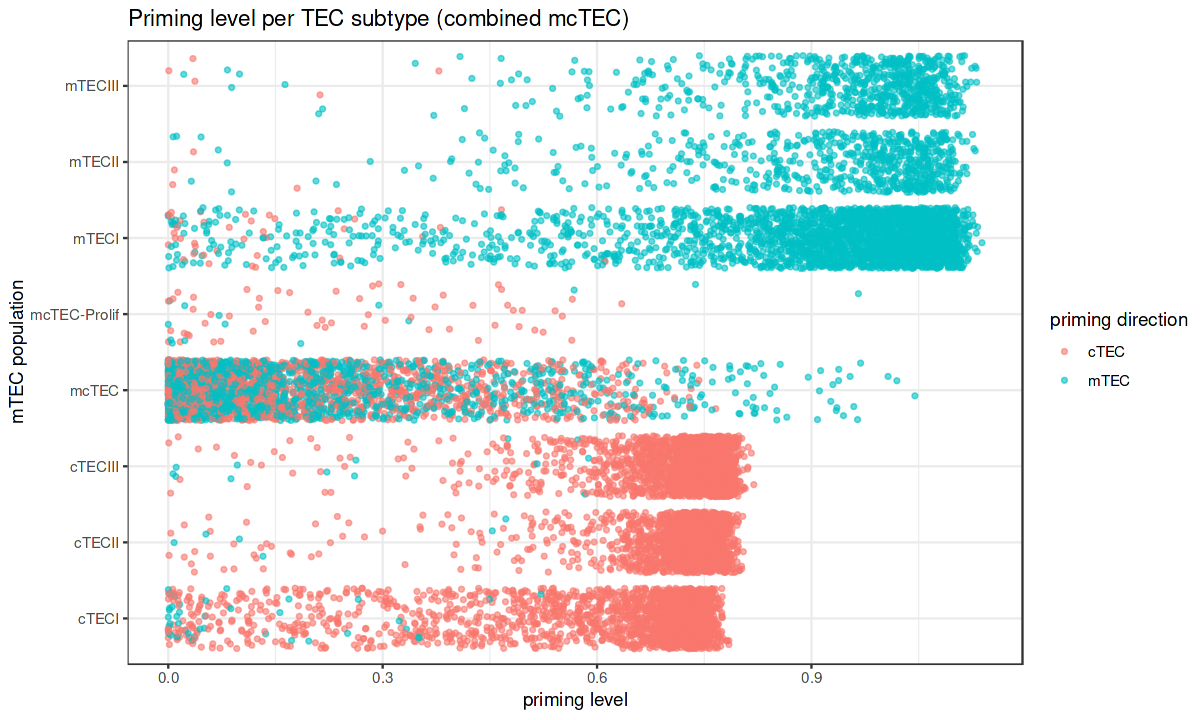

In [44]:
options(repr.plot.width=10, repr.plot.height=6)


ggplot(stemnet2_df, aes(x=amount, y=ident, color=direction))+
geom_jitter(size=1, alpha=0.6)+
labs(title='Priming level per TEC subtype (combined mcTEC)', x='priming level', y='mTEC population', color='priming direction')+
theme_bw()

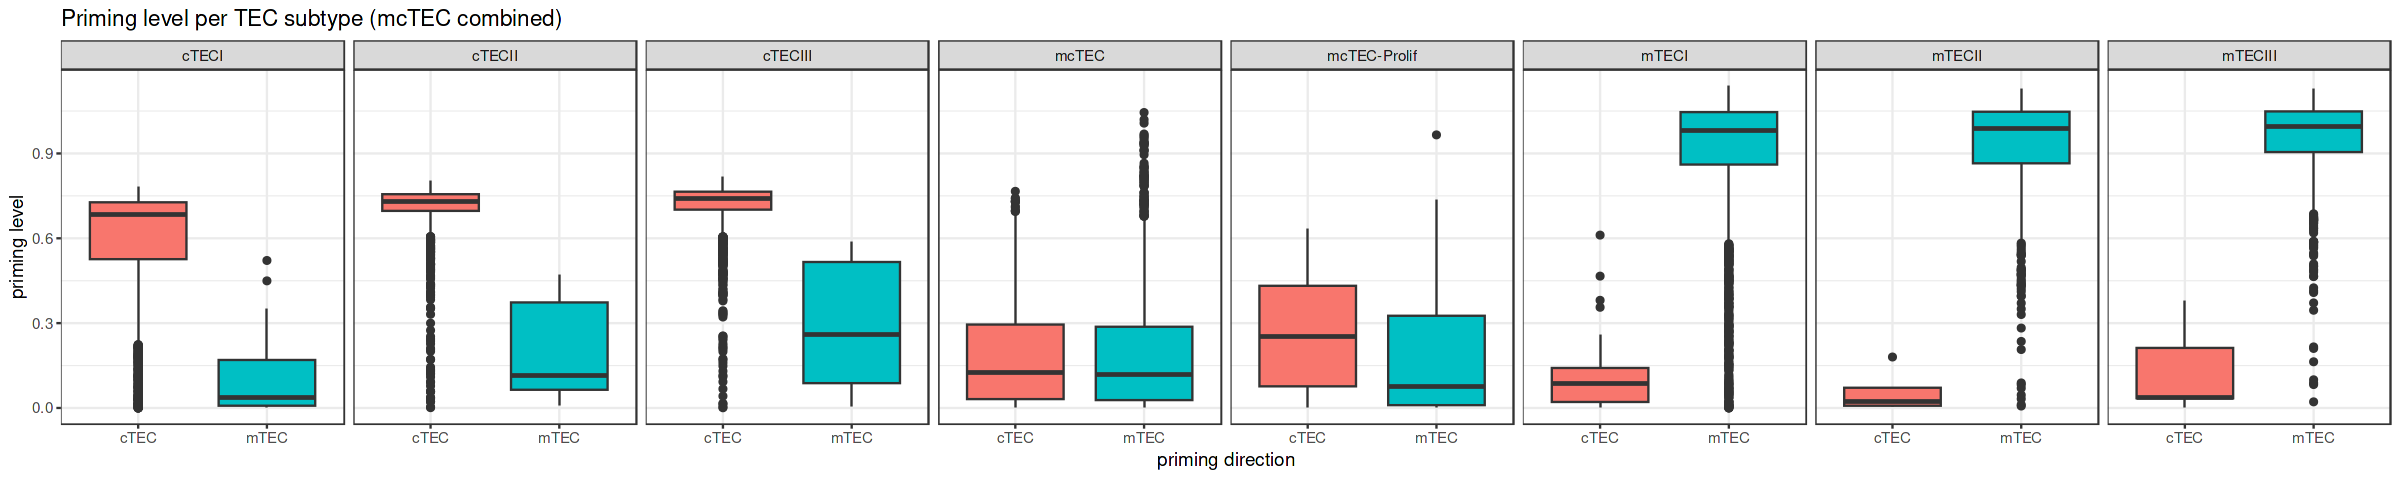

In [45]:
options(repr.plot.width=20, repr.plot.height=4)

ggplot(stemnet2_df, aes(y=amount, x=direction, fill=direction))+
geom_boxplot()+
facet_wrap(~ident, ncol=9)+
labs(title='Priming level per TEC subtype (mcTEC combined)', y='priming level', x='priming direction')+
theme_bw()&NoLegend()

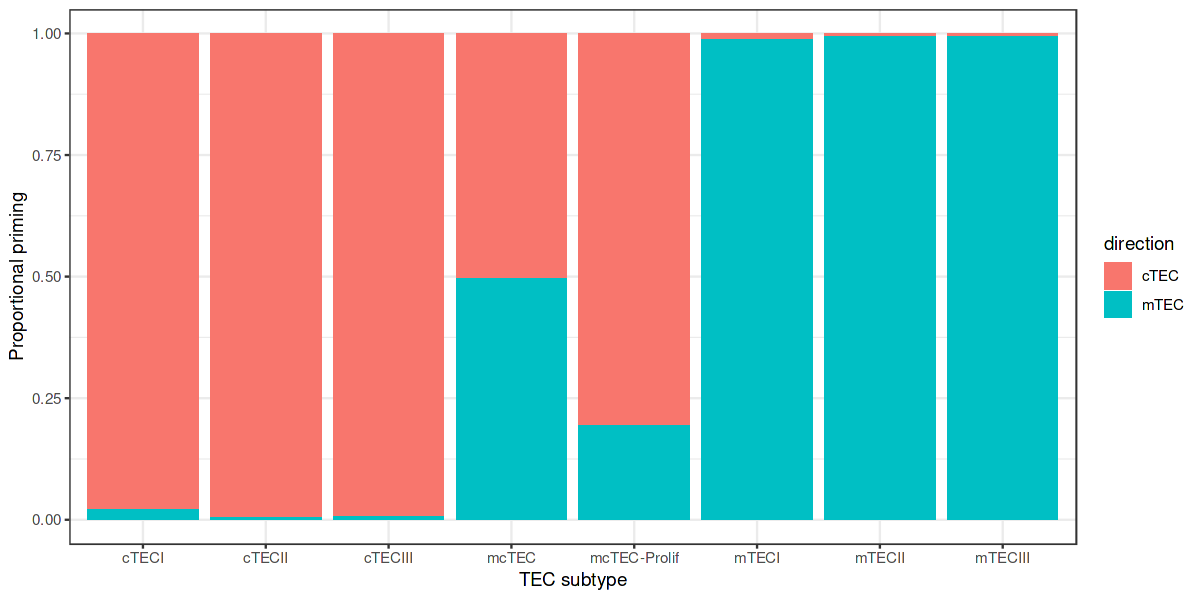

In [46]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(stemnet2_df, aes(x=ident, fill=direction))+
geom_bar(stat = 'count', position='fill')+
labs('Proportional TEC priming per TEC subtype (split mcTEC)', y='Proportional priming', x='TEC subtype', color='priming direction')+
theme_bw()

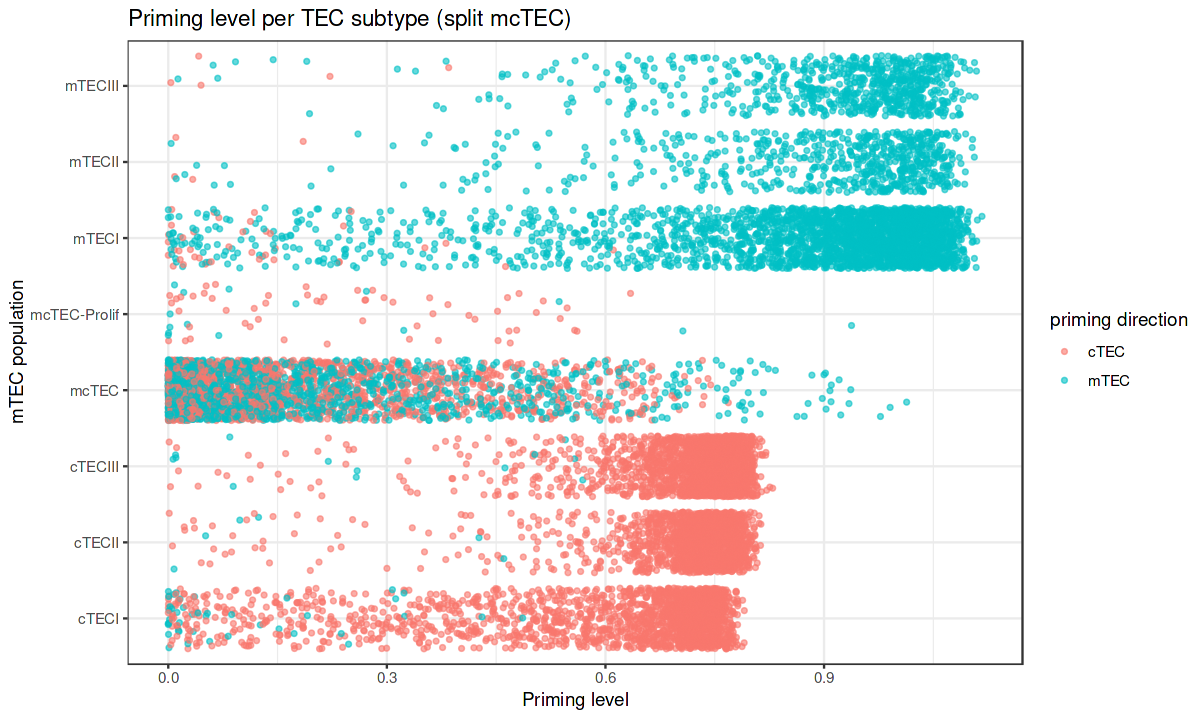

In [12]:
options(repr.plot.width=10, repr.plot.height=6)


ggplot(stemnet2_df, aes(x=amount, y=ident, color=direction))+
geom_jitter(size=1, alpha=0.6)+
labs(title='Priming level per TEC subtype (split mcTEC)', x='Priming level', y='mTEC population', color='priming direction')+
theme_bw()

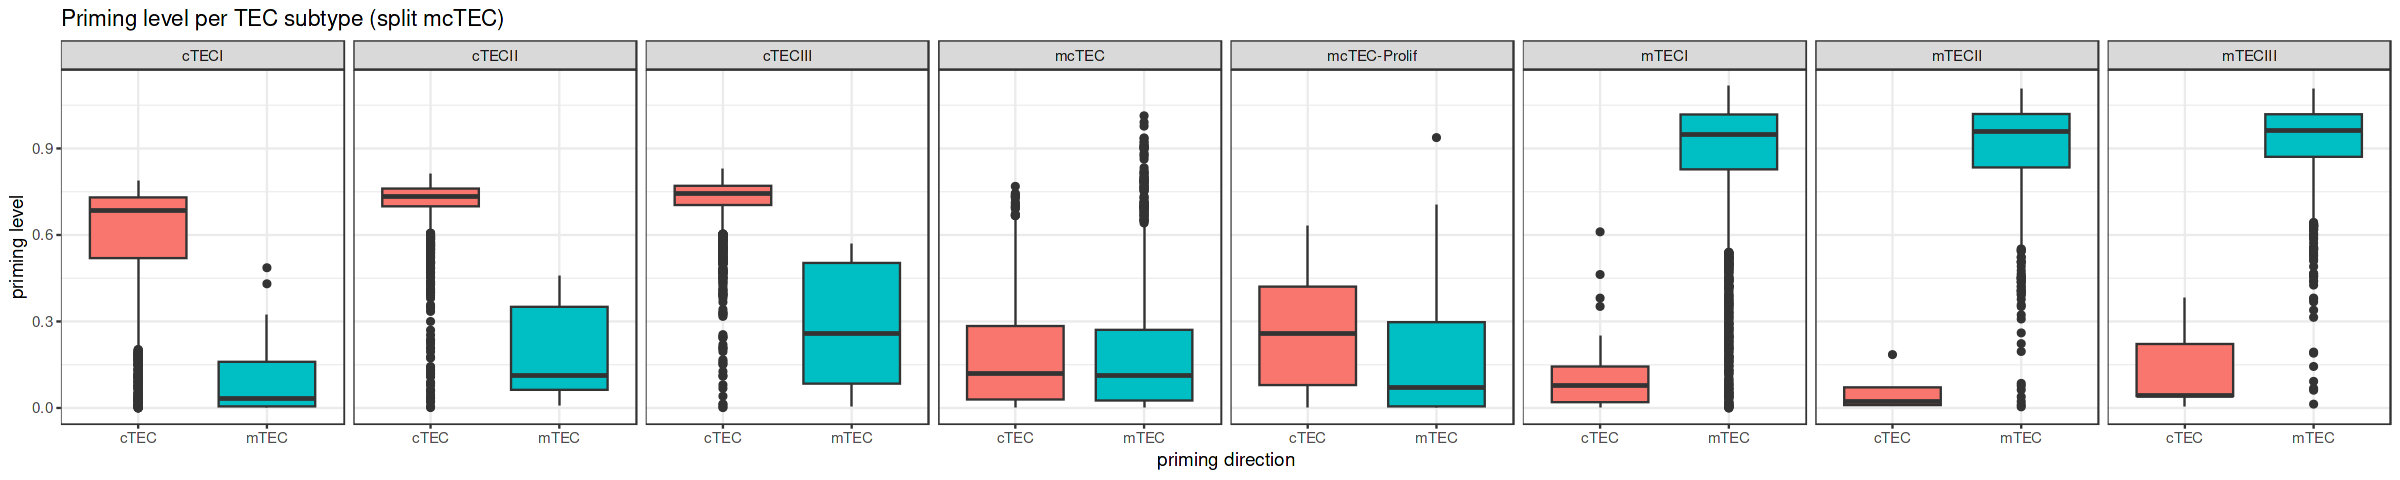

In [11]:
options(repr.plot.width=20, repr.plot.height=4)

ggplot(stemnet2_df, aes(y=amount, x=direction, fill=direction))+
geom_boxplot()+
facet_wrap(~ident, ncol=9)+
labs(title='Priming level per TEC subtype (split mcTEC)', y='priming level', x='priming direction')+
theme_bw()&NoLegend()

In [53]:
stemnet2_allprobs_mcTEC <- stemnet2_df[stemnet2_df$ident %in% c("mcTEC", "mcTEC-Prolif"),]

In [55]:
stemnet2_allprobs_mcTEC$potential_CvsM <- (stemnet2_allprobs_mcTEC$cTEC-stemnet2_allprobs_mcTEC$mTEC)

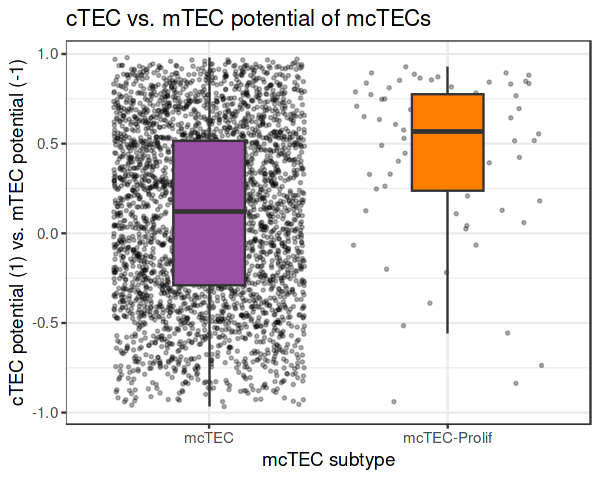

In [58]:
options(repr.plot.width=5, repr.plot.height=4)

ggplot(stemnet2_allprobs_mcTEC, aes(x=ident, y=potential_CvsM, fill=ident))+
geom_jitter(alpha=0.3, size=0.5)+
scale_fill_manual(values=pal1[4:5])+
geom_boxplot(width=0.3, outlier.shape = NA)+
labs(title='cTEC vs. mTEC potential of mcTECs', x='mcTEC subtype', y='cTEC potential (1) vs. mTEC potential (-1)')+
theme_bw()&NoLegend()

In [18]:
stemnet_allprobs_mcTEC$potential_CvsM_categ <- ifelse(stemnet_allprobs_mcTEC$potential_CvsM > 0.5, 'high', ifelse(stemnet_allprobs_mcTEC$potential_CvsM  < -0.5, 'low', 'medium'))

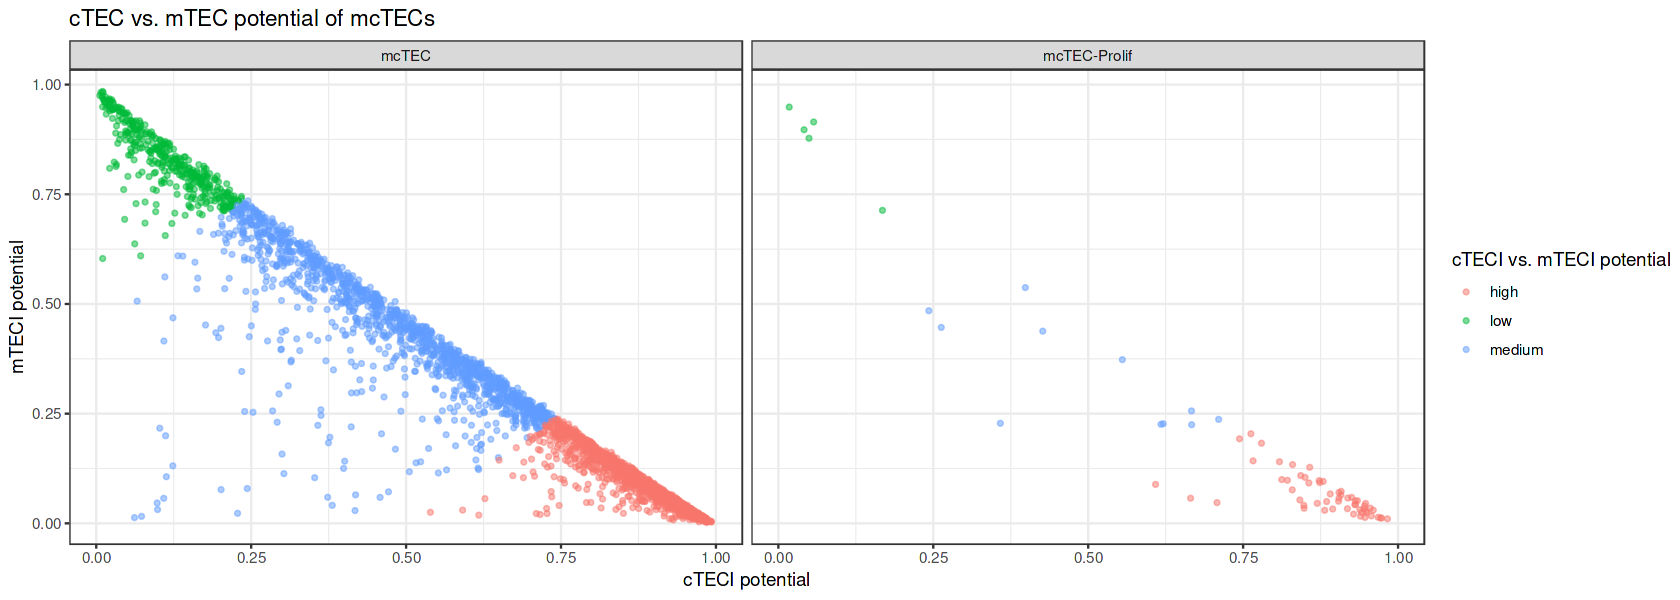

In [19]:
options(repr.plot.width=14, repr.plot.height=5)

ggplot(stemnet_allprobs_mcTEC, aes(x=cTECI, y=mTECI, color=potential_CvsM_categ))+
geom_jitter(size=1, alpha=0.5)+
facet_grid(~ident)+
labs(title='cTEC vs. mTEC potential of mcTECs', x='cTECI potential', y='mTECI potential', color='cTECI vs. mTECI potential')+
theme_bw()

### Prepare for mapping

New annotations based on high/low potential were used for new Visium deconvolution to determine if potential is associated with specific tissue niche.

In [ ]:
seurObj_TEC_subs$potential_cTECI <- stemnet_allprobs$cTECI
seurObj_TEC_subs$potential_cTECII <- stemnet_allprobs$cTECII
seurObj_TEC_subs$potential_cTECIII <- stemnet_allprobs$cTECIII
seurObj_TEC_subs$potential_mTECI <- stemnet_allprobs$mTECI
seurObj_TEC_subs$potential_mTECII <- stemnet_allprobs$mTECII
seurObj_TEC_subs$potential_mTECIII <- stemnet_allprobs$mTECIII
seurObj_TEC_subs$potential_label <- stemnet_allprobs$direction
seurObj_TEC_subs$potential_cTECIvsmTECI <- stemnet_allprobs$cTECI-stemnet_allprobs$mTECI
seurObj_TEC_subs$potential_cTECIvsmTECI_categ <- ifelse(seurObj_TEC_subs$potential_cTECIvsmTECI > 0.5, 'high', ifelse(seurObj_TEC_subs$potential_cTECIvsmTECI  < -0.5, 'low', 'medium'))

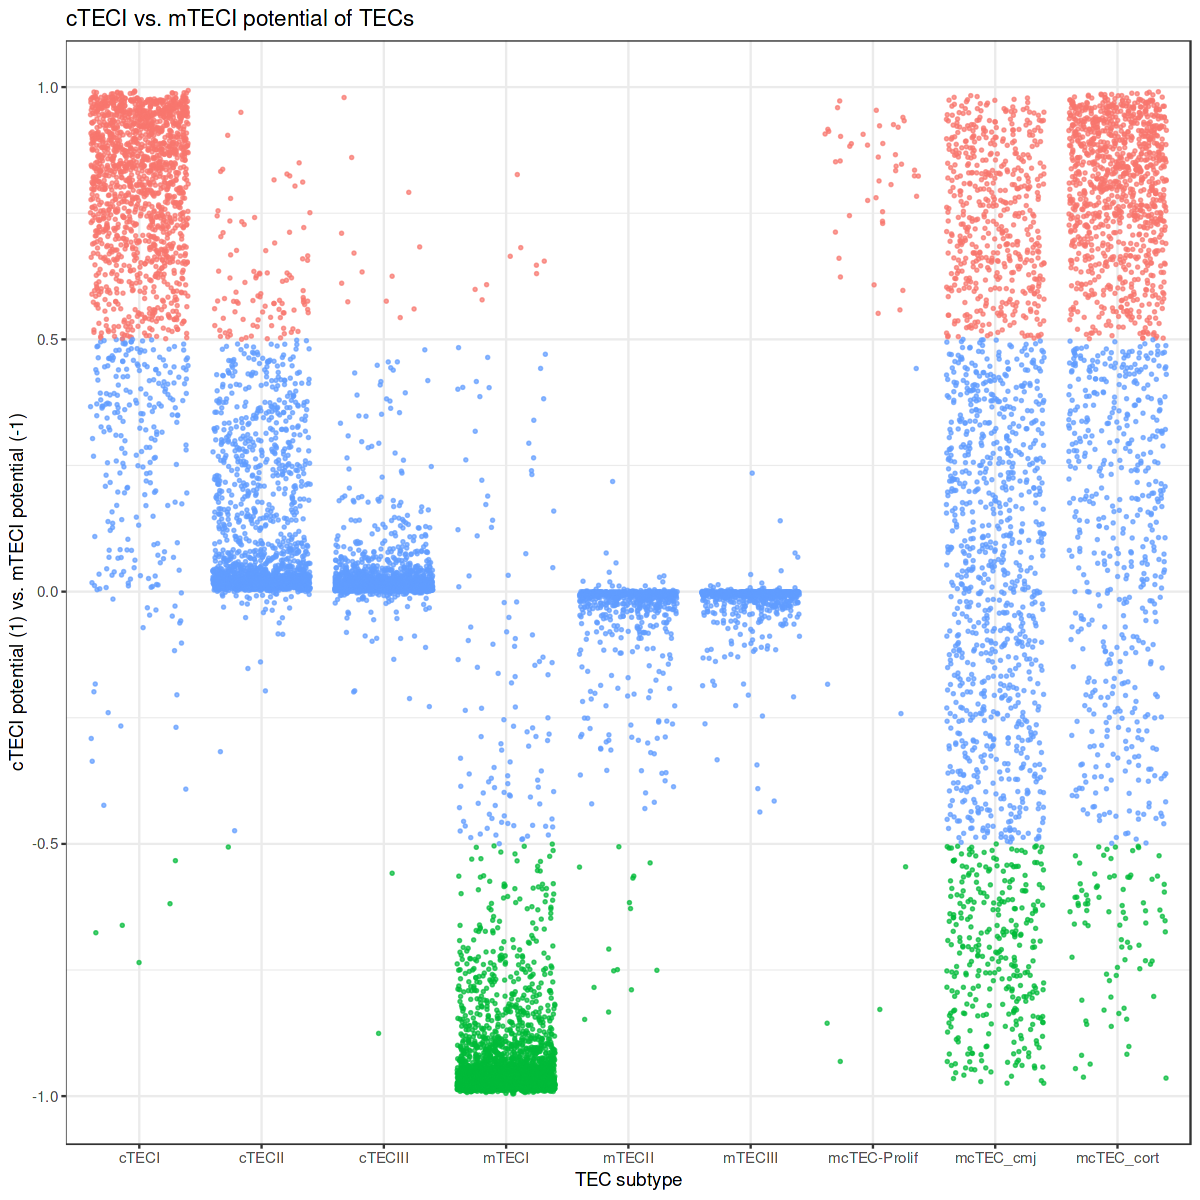

In [14]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(seurObj_TEC_subs@meta.data, aes(x=cell_type_level_4_upd2, y=potential_cTECIvsmTECI, color=potential_cTECIvsmTECI_categ))+
geom_jitter(alpha=0.7, size=0.5)+
scale_fill_manual(values=pal4)+
labs(title='cTECI vs. mTECI potential of TECs', x='TEC subtype', y='cTECI potential (1) vs. mTECI potential (-1)')+
theme_bw()&NoLegend()

In [15]:
table(seurObj_TEC_subs$cell_type_level_4_upd2, seurObj_TEC_subs$potential_cTECIvsmTECI_categ)

               
                high  low medium
  TEC-cilliated    0    0      0
  TEC-ionocytes    0    0      0
  TEC-myo          0    0      0
  TEC-neuro        0    0      0
  cTECI         1522    5    256
  cTECII          98    1   1515
  cTECIII         13    2   2127
  mTECI            9 2619    110
  mTECI-Prolif     0    0      0
  mTECI-trans      0    0      0
  mTECII           0   15    656
  mTECIII          0    0    745
  mcTEC-Prolif    43    4      3
  mcTEC_cmj      525  316    893
  mcTEC_cort    1040   84    504

In [ ]:
write.csv(seurObj_TEC_subs@meta.data, file='TECs_stemnet.csv')

In [ ]:
save.image('stemnet.RData')

### Plotting

In [6]:
load("palettes.RData")

In [13]:
pal_TEC <- c('#540004', '#9a4d3a', '#fdc683', '#fc7d57', '#d2448e', '#bf003c', '#48a7ec', '#a84c57')
pal_mcTEC <- c('#d45e01', '#efe441', '#0272b2')

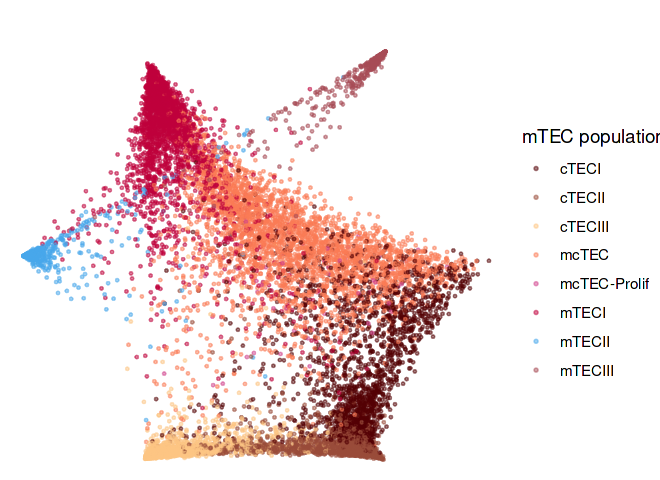

In [15]:
options(repr.plot.width=5.5, repr.plot.height=4)

plot_all <- ggplot(stemnet_df, aes(x=x, y=y, color=ident))+
       rasterise(geom_point(size=0.5, alpha=0.5), dpi=300)+
        scale_color_manual(values = pal_TEC)+
        theme_void()+
        labs(title = '', color='mTEC population', shape='priming direction')
plot_all

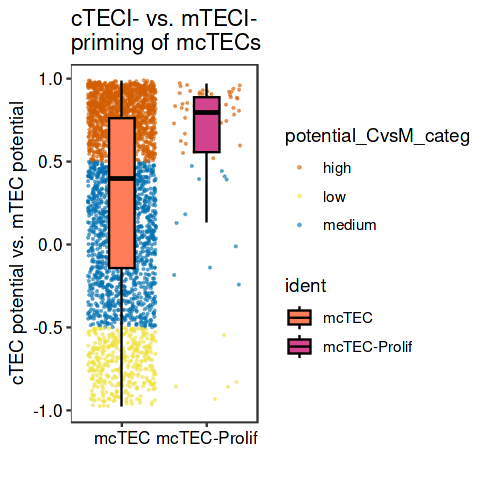

In [20]:
options(repr.plot.width=4, repr.plot.height=4)

plot_priming <- ggplot(stemnet_allprobs_mcTEC, aes(x=ident, y=potential_CvsM, fill=ident, color=potential_CvsM_categ))+
rasterise(geom_jitter(alpha=0.5, size=0.3), dpi=300)+
scale_fill_manual(values=pal_TEC[4:5])+
scale_color_manual(values=pal_mcTEC)+
geom_boxplot(width=0.3, outlier.shape = NA, color='black')+
theme_bw()+
theme(axis.text.x = element_text(size=10, color='black'), axis.text.y = element_text(size=10, color='black'), ,
          panel.grid = element_blank())+
labs(title='cTECI- vs. mTECI- \npriming of mcTECs', x='', y='cTEC potential vs. mTEC potential')

plot_priming